<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/vision-nas-search-keras-cifar-ray/mininas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniNAS Neural Architecture Search using SigOpt and Ray Tune

Neural Architecture Search (NAS) is a modern technique to find optimized neural networks for a given task such as image classification, through structural iteration and permutation. Network parameters such as the depth of a network, number of convolutional filters, pooling, epochs and learning rate can substantially impact a network’s accuracy, inference throughput, and latency for a given dataset.

The search space for these parameters is large, and as a result, NAS can take many hours of compute to train, sometimes requiring additional compute resources. In this article, we show how you can use smarter search algorithms provided by SigOpt paired with raw cluster compute power provided by Ray Tune to accelerate this search process. We use a simple example so that a practitioner can apply this technique to their own workflow.

To illustrate the core concept of NAS, consider the original network in Figure (a) below. This reference network consists of a single input layer followed by one or more copies of Block 1. Block 1 is based on a convolution-pooling motif consisting of 3x3 convolutions with 32 filters, optionally followed by a pooling operation. This pattern continues with one or more copies of Block 2, similarly composed of 32 3x3 convolutional filters. These convolutional blocks are then flattened to a vector, processed through a fully connected layer, and topped off with a softmax function for final classification.

NAS helps the data scientist to test out a variety of  permutations of a reference architecture. Figure (b) shows one  option called “depth scaling,” in which Block 2 is repeated to increase the effective depth of the network. For good measure, we also optionally add another fully connected layer of 1024 neurons. In this tutorial, the two fully connected layers are the same size, but they can be different sizes in your application.

Figure (c) shows “width scaling,” in which the depth of the network remains constant but parameters on the operators are varied. In this case, we reduce the number of convolutions in L1 (layer 1) from 32 to 16, and increase the number of convolutions in L2 from 32 to 64. We also make the fully connected layer wider going from 1024 to 2048. Note that NAS doesn't have to search for  all parameters at once. It's possible to optimize one parameter at a time and fix the others or if your optimizer is intelligent like SigOpt, it's both possible and more efficient to strategically update multiple parameters at once to find the best network architecture more quickly.

Figure (d) explores yet one more dimension by challenging our assumption of using 3x3 filters. Instead, we substitute the filters in Block 1 with 5x5 sized filters and Block 2 with 7x7 sized filters. This can help the performance of certain models and datasets, depending on data characteristics and input image resolution.

By now, it's fairly clear that even with a simple example, there are a combinatorially large number of neural networks parameters to customize and explore. In the rest of this article, we will show you how to use SigOpt and Ray Tune to fine tune the space of simple neural networks used to classify images in the classic CIFAR10 dataset.

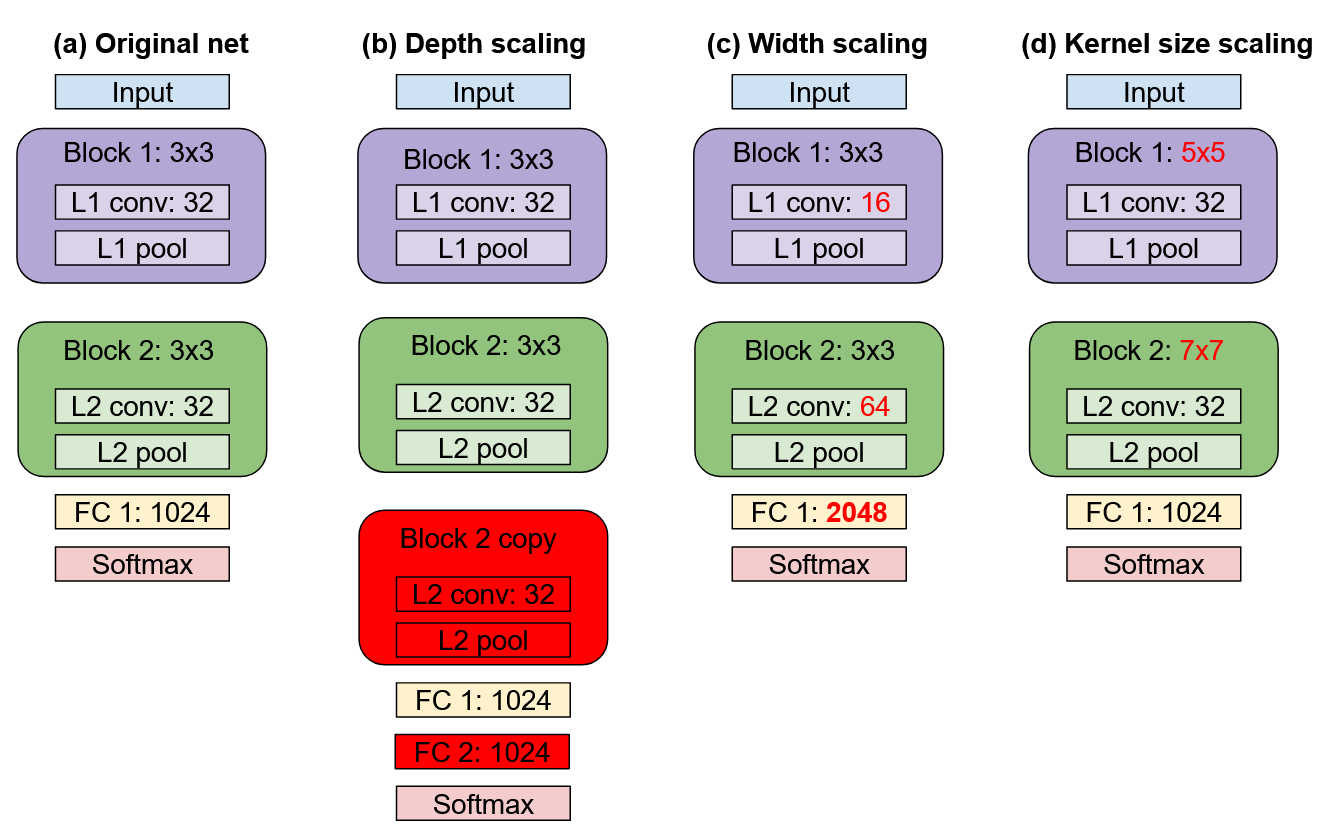

### Overall workflow
1. Define a neural network training task: choose a dataset and a model template (e.g. CIFAR10; convolutional neural net (CNN)). Define parameters to tune (e.g. number of layers and/or filters).
1. Apply Ray Tune to search for a preliminary? set of model parameters.
1. Adapt search algorithm to SigOpt to get better parameters efficiently.

### Parameterizing the model
For the purposes of this article, we define a neural network training task as a convolutional network with one or more convolutional blocks. we will use the CIFAR 10 dataset and the Keras API from TensorFlow.

In [ ]:
# Install prerequisites
!python3 -m pip install -qqq "ray[tune]" pandas

# Download dataset
from tensorflow.keras.datasets import cifar10
d = cifar10.load_data()

# Ray Tune will call this function many times in parallel with different hyperparameters
def train(config):
    import os, numpy as np
    import psutil
    os.environ['OMP_NUM_THREADS'] = str(int(psutil.cpu_count()/2))
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

    # Load the dataset
    (X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

    # Create the model
    model = Sequential()

    # Build first convolutional block motif
    model.add(Conv2D(config['nconv0'], kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
    for i in range(config['nblocks1']):                                               # Repeat this block nblocks1 times
        if len(model.layers) > config['layers']: break                                # Limit depth to "layers"
        model.add(Conv2D(config['nconv1'], kernel_size=(3, 3), activation='relu'))    # Add nconv1 3x3 conv kernels with relu activation
        if config["pooling"] == "True": model.add(MaxPooling2D(pool_size=(2, 2)))     # Add pooling
        model.add(Dropout(0.25))                                                      # Add dropout

    for i in range(config['nblocks2']):
        if len(model.layers) > config['layers']: break
        model.add(Conv2D(config['nconv2'], kernel_size=(3, 3), activation='relu'))
        if config["pooling"] == "True": model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())                                                              # Flatten output tensor to a vector
    for i in range(config['nfcll']):                                                  # number of fully connected last layers
        if len(model.layers) > config['layers']: break
        model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))                                        # Apply softmax classification
    print("Layers: %d max layers: %d" % (len(model.layers), config['layers']))

    # Compile and setup training
    from tensorflow.keras.utils import to_categorical
    model.compile(loss='categorical_crossentropy',
      # Adam uses an adaptive learning rate that we do not explicitly tune this
      optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

    # Train the model
    model.fit(X_train / 255.0, to_categorical(Y_train),
      batch_size=128, shuffle=True, verbose=0,
      epochs=config["epochs"])
    
    # Evaluate the model
    scores = model.evaluate(X_test / 255.0, to_categorical(Y_test))
    tune.report(Accuracy=scores[1], Loss=scores[0])

def train_wrapper(config):
  try:
    train(config)
  except ValueError:
    # Sometimes applying pooling too many times shrinks the tensors too much and dimensions go negative
    print("Invalid neural net sampled")
    tune.report(Accuracy=0, Loss=999)

## To parameterize the model, we define the following:
* `Epochs` — Number of epochs to train a model
* `Layers` — Maximum number of layers of the desired model (subsequent layers are pruned)
* `Nconv0` — Number of 3x3 convolution filters for the input layer
* `Nfcll` — Number of fully-connected last layers, with 1024 neurons each
* `Pooling` — Global setting to enable/disable pooling in convolution blocks #1 and #2
## Convolution block #1
* `Nblocks1` — Number of copies of convolution block #1
* `Nconv1` — Number of 3x3 convolution filters for block #1
## Convolution block #2
* `Nblocks2` — Number of copies of convolution block #2
* `Nconv2` — Number of 3x3 convolution filters for block #2

In [ ]:
# Start Ray from command line
# NB: We do this to be consistent for deploying clusters in part 2 (to be published later)
# If running on a single node, this cell isn't needed
!ray stop
!sleep 3
!nohup ray start --head --num-cpus 1
!sleep 3
import ray
ray.init('localhost:6379')

In [ ]:
# Start multiple workers if running on a qsub cluster such as Intel DevCloud - run on 4 nodes (1 head node)
!which qsub && echo ray start --address `hostname`:6379 --block --num-cpus 1 | qsub
!which qsub && echo ray start --address `hostname`:6379 --block --num-cpus 1 | qsub
!which qsub && echo ray start --address `hostname`:6379 --block --num-cpus 1 | qsub
!which qsub && sleep 20

In [ ]:
from ray import tune
config = {
        "epochs":   tune.randint(20, 30),
        "layers":   tune.randint(1, 20),     # max number of layers, layers past this are ignored
        "nconv0":   tune.randint(16, 64),    # input layer
        "nfcll" :   tune.randint(0, 2),      # fully connected last layer

        "nblocks1": tune.randint(1, 3),      # conv block 1
        "nconv1":   tune.randint(16, 64),
        "nblocks2": tune.randint(1, 3),      # conv block 2
        "nconv2":   tune.randint(16, 64),
        "pooling" : tune.choice(['True', 'False'])
    }

## Apply Ray Tune
Ray Tune is a Python library that facilitates scaled experimentation, as well as hyperparameter optimization via SigOpt that allows multiple worker nodes to explore the search space in parallel. A naive grid search of our defined parameter space would explore nearly 1.2 billion possible configurations. In this article, we show how to use random search to speed up this process, and follow up with a smarter guided search using SigOpt, effectively comparing the performance and output of the two approaches.

For Ray Tune, the most important inputs are the function to optimize (train) and the search space for the parameters (config). We defined both of these earlier and provide the corresponding code below. Other options include a choice of search algorithm and scheduler for more guided searches.

Note: A rounded 1.2 billion is derived from ```10*20*(64-16)*3*3*(64-16)*3*(64-16)*2```

In [ ]:
tune_opts = { # Common options for Ray tune
    'num_samples':  5,                   # Number of sample points to try, increase for better results
    'raise_on_failed_trial': False       # Some net configs are invalid (pooling too many times creates negative dim)
}

In [ ]:
import subprocess, psutil

# Enable accelerator if present
try:
  if subprocess.run('nvidia-smi').returncode == 0:
    tune_opts['resources_per_trial'] = {'cpu': 1, 'gpu': 1}
except FileNotFoundError: pass

In [ ]:
analysis = tune.run(
    train_wrapper,
    config=config,
    verbose=1,
    **tune_opts)

In [ ]:
# To see the full optimization results, inspect the results dataframe
analysis.results_df

In [ ]:
# Visualize Ray Tune results
d = analysis.results_df
d.plot.scatter('timestamp', 'Accuracy')

# Integrating with SigOpt
To sign up for free access to SigOpt, please use this [sign-up form](https://app.sigopt.com/signup). You’ll then be able to create an account, which will give you access to an API key, which you’ll fill in in your Google Colab notebook or DevCloud Jupyter notebook.

![SigOpt Sign-Up](https://sigopt.com/wp-content/uploads/2021/05/signup_screen.png)
![Your API Key](https://sigopt.com/wp-content/uploads/2021/05/apikey.png)

In [ ]:
# Fill in your SigOpt key here
SIGOPT_TOKEN   = "XWBIVDWCVQXALUZQFDHNGOELLLKDJBMOJALEPCNQXQGBNIGC"
SIGOPT_PROJECT = "raytune-simplenas"
!pip install -qqq sigopt

In [ ]:
# Convert Ray Tune parameter space to SigOpt format
def convert_space_to_sigopt(config):
    c = []
    for k, v in config.items():
        print(k,v)
        if isinstance(v, ray.tune.search.sample.Float):
            c.append({'name': k, 'type': 'double', 'bounds': {'min': v.lower, 'max': v.upper}})
        elif isinstance(v, ray.tune.search.sample.Integer):
            c.append({'name': k, 'type': 'int', 'bounds': {'min': int(v.lower), 'max': int(v.upper)}})            
        elif isinstance(v, ray.tune.search.sample.Categorical):
            vals = [{'enum_index': i+1, 'name': str(z), 'object': 'categorical_value'} for i, z in enumerate(v.categories)]
            c.append({'name': k, 'type': 'categorical', 'categorical_values': vals})
        else: 
            print('Unknown type:', k, type(v))
            raise ValueError
    print('config:', c)      
    return c

In [ ]:
import ray, os, sigopt
from ray.tune.search.sigopt import SigOptSearch
from ray.tune.schedulers import FIFOScheduler
sigopt_connection = sigopt.Connection(client_token=SIGOPT_TOKEN)

algo = SigOptSearch(
    convert_space_to_sigopt(config),
    name=SIGOPT_PROJECT,
    connection=sigopt_connection,
    max_concurrent=3,
    metric="Accuracy",
    mode="max")

analysis_sigopt = tune.run(
    train_wrapper,
    search_alg=algo,
    verbose=1,
    **tune_opts)

In [ ]:
analysis_sigopt.results_df

In [ ]:
# Visualize Ray Tune results
a = analysis.results_df[['timestamp', 'Accuracy']]
s = analysis_sigopt.results_df[['timestamp', 'Accuracy']]
a['timestamp'] -= a['timestamp'].min()
s['timestamp'] -= s['timestamp'].min()
ax = a.plot.scatter('timestamp', 'Accuracy', c='b', label='Random Search- Acc %0.3f%%' % a['Accuracy'].max())
s.plot.scatter('timestamp', 'Accuracy', c='r', ax=ax, label='SigOpt- Acc %0.3f%%' % s['Accuracy'].max(), title='Accuracy vs time')
ax.legend(loc='lower right')

# Interpreting SigOpt results
In the example above, we used a limited number of sample points to allow this experiment to complete quickly. If more data points are sampled, you might see a figure like the one shown below. This illustrates that SigOpt's directed search helps find better solutions more efficiently than random search.

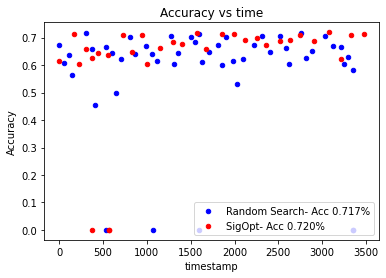

SigOpt helps data scientists understand which parameters matter most for their NAS. Below, we see that the number of epochs has the biggest influence on the accuracy of the network, followed by pooling layers, and then the number of convolutional filters. SigOpt searches this space intelligently to find the best values efficiently.

To help data scientists understand the influence of various parameters, SigOpt visualizes the relative parameter importance with respect to the points sampled. Note that this is a bit of a biased sample as the points are chosen intelligently by the optimizer (instead of at random).

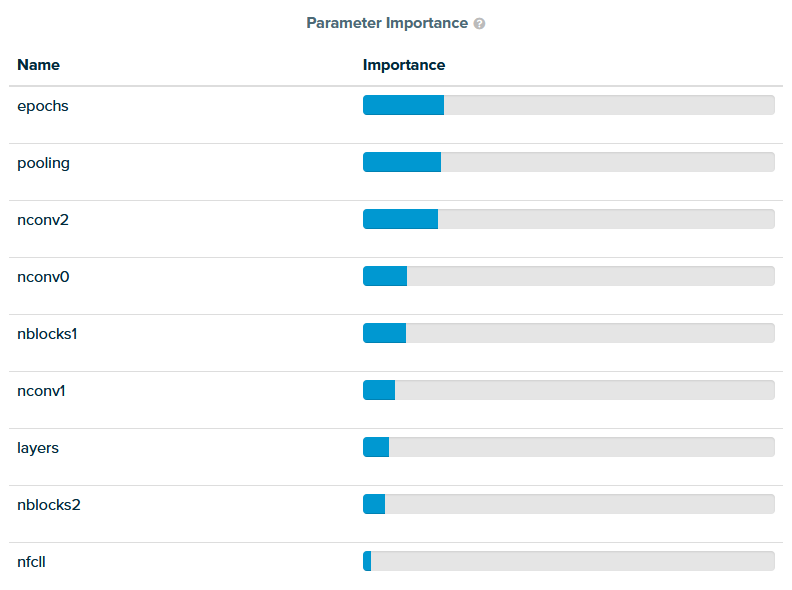

Given the relative importance of the parameters, we examine the relationship between convolutional filter parameters `nconv0` and `nconv1` and find that this particular problem prefers around 50 filters for `nconv0 and a small number of filters for nconv1. Any pair of variables can be visualized in this plot.

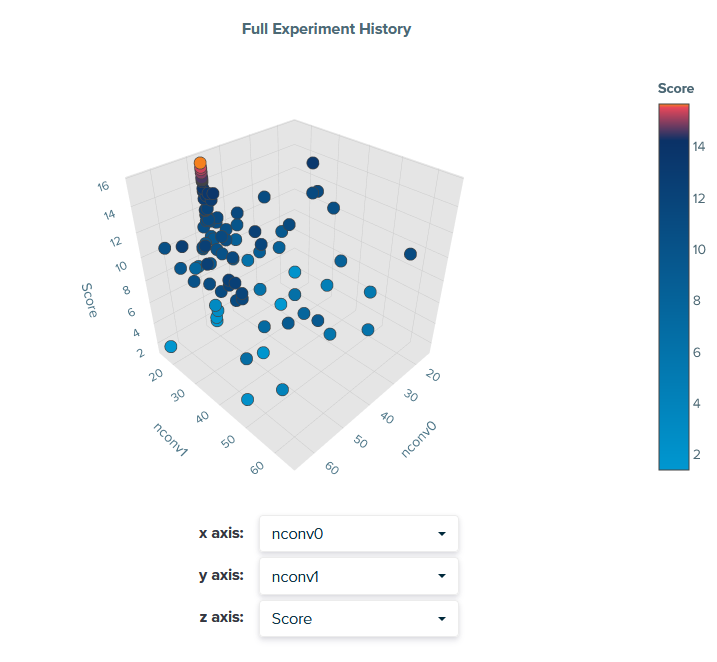

A parallel coordinates plot shows the trajectory of the parameter search. In this case, the highest scores are obtained with a larger number of epochs, pooling, and different combinations of layer parameters. This plot shows what this particular problem prefers. As the dataset or objective is changed, the preferred parameters may differ.

Understanding the relationships between the parameters can help a data scientist better optimize parameter values for the problem and better manage tradeoffs.

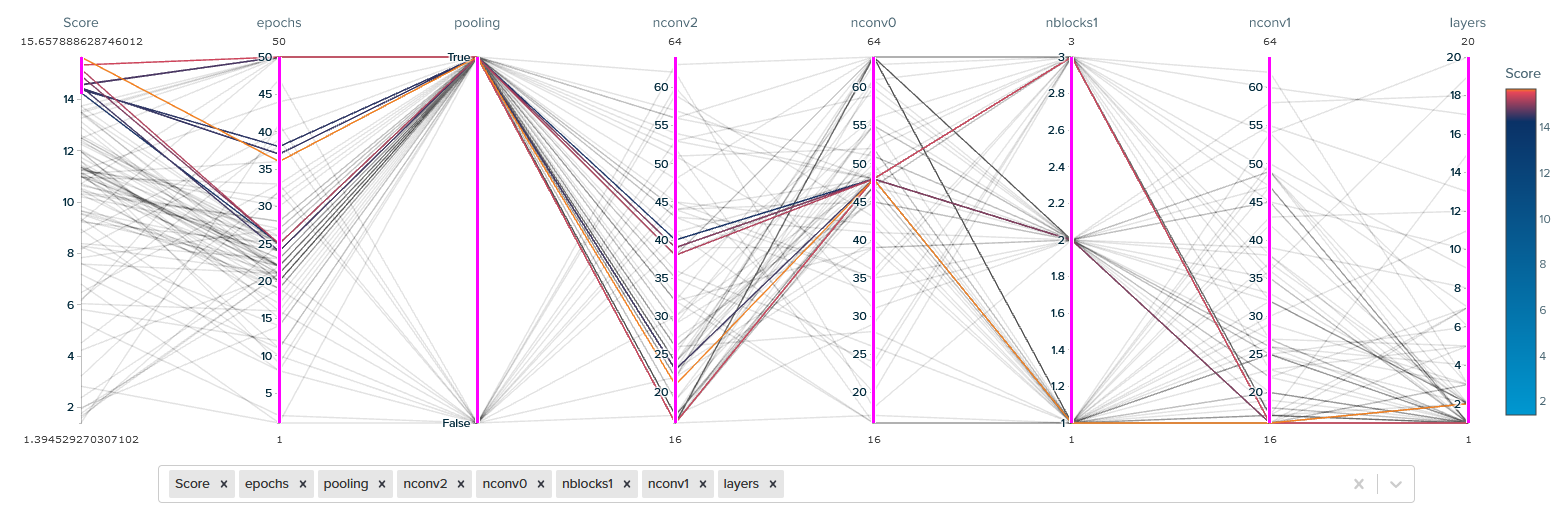

Feel free to [try this notebook out for yourself on Google Colab](https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/vision-nas-search-keras-cifar-ray/mininas.ipynb) or Intel's own [DevCloud](https://devcloud.intel.com/oneapi). Be sure to [sign up for free access to SigOpt](https://app.sigopt.com/signup), and start optimizing, tracking, and systematizing today.

<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/vision-nas-search-keras-cifar-ray/mininas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>